<a href="https://colab.research.google.com/github/cindyy-chen/iss_movement/blob/main/Jan_2024_Tracking_the_International_Space_Station_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **Step 0: Loading modules**


In [ ]:
!pip install global_land_mask
!pip install meteostat
!pip install movingpandas
!pip install hvplot
!pip install geopy
!pip install countryinfo
!pip install holoviews
!pip install reverse_geocode
!pip install catropy
!pip install geoview

In [116]:
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
from pathlib import Path
import requests

In [118]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [119]:
import os
import numpy as np

In [120]:
from global_land_mask import globe

In [121]:
import datetime as dt
import meteostat as met

In [158]:
from geopy.geocoders import Nominatim
from countryinfo import CountryInfo
from shapely import geometry as shpgeom
from shapely import wkt as shpwkt
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import hvplot.pandas
import reverse_geocode
from countryinfo import CountryInfo
from geopy.geocoders import Nominatim

ERROR: Could not find a version that satisfies the requirement catropy (from versions: none)
ERROR: No matching distribution found for catropy
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [123]:
import holoviews as hv
import hvplot.pandas
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [124]:
plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
hv.opts.defaults(hv.opts.Overlay(active_tools=['wheel_zoom'],
                              frame_width=500, frame_height=400))
hvplot_defaults = {'tiles':None, 'cmap':'Viridis', 'colorbar':True}

In [125]:
mpd.show_versions()


MovingPandas 0.17.2

SYSTEM INFO
-----------
python     : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
executable : /usr/bin/python3
machine    : Linux-6.1.58+-x86_64-with-glibc2.35

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.6.4
GDAL data dir: /usr/local/lib/python3.10/dist-packages/fiona/gdal_data
PROJ       : 9.3.0
PROJ data dir: /usr/local/lib/python3.10/dist-packages/pyproj/proj_dir/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.13.2
pandas     : 1.5.3
fiona      : 1.9.5
numpy      : 1.23.5
shapely    : 2.0.2
rtree      : 1.2.0
pyproj     : 3.6.1
matplotlib : 3.7.1
mapclassify: None
geopy      : 2.3.0
holoviews  : 1.17.1
hvplot     : 0.9.1
geoviews   : None
stonesoup  : None


In [126]:
file_name = "/content/drive/My Drive/iss_timeseries_trajectories_20230921_165844.csv"
df = pd.read_csv(file_name, sep=",")
df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3001 entries, 0 to 3000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   3001 non-null   float64
 1   longitude  3001 non-null   float64
 2   timestamp  3001 non-null   float64
 3   traj_id    3001 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 93.9 KB


---
# **Step 1: Read the CSV File**


In [127]:
file_name = "https://raw.githubusercontent.com/cindyy-chen/iss_movement/main/iss_timeseries_trajectories_20230921_165844.csv"
df = pd.read_csv(file_name, sep=",")
df

,latitude,longitude,timestamp,traj_id
0,-23.8283,94.9158,1.695330e+09,0
1,-24.0652,95.1346,1.695330e+09,0
2,-24.3254,95.3763,1.695330e+09,0
3,-24.5616,95.5969,1.695330e+09,0
4,-24.8209,95.8407,1.695330e+09,0
...,...,...,...,...
2996,31.2693,339.6484,1.695346e+09,2
2997,31.0465,339.9017,1.695346e+09,2
2998,30.8230,340.1538,1.695346e+09,2
2999,30.5765,340.4296,1.695346e+09,2


In [128]:
# from google.colab import drive
# drive.mount('/content/drive')
# !ls drive/MyDrive/iss*

In [129]:
# file_dir = "/content/drive/My Drive/"
# os.listdir(file_dir)
# file_name = os.path.join(file_dir, "iss_timeseries_trajectories_20230921_165844.csv")

In [130]:
# file_name = "/content/drive/My Drive/iss_timeseries_trajectories_20230921_165844.csv"
# df = pd.read_csv(file_name, sep=",")
# df

# **Step 2: Perform Conversions**
---

Convert longitude from 0 to 360 into -180 to 180:

In [131]:
df['longitude'] = (df['longitude'] + 180) % 360 - 180

Convert the positions (latitude and longitude) into Shapely POINT objects:

In [132]:
df['geometry'] = [shpgeom.Point(xy) for xy in zip(df['longitude'], df['latitude'])]
df

,latitude,longitude,timestamp,traj_id,geometry
0,-23.8283,94.9158,1.695330e+09,0,POINT (94.91579999999999 -23.8283)
1,-24.0652,95.1346,1.695330e+09,0,POINT (95.13459999999998 -24.0652)
2,-24.3254,95.3763,1.695330e+09,0,POINT (95.37630000000001 -24.3254)
3,-24.5616,95.5969,1.695330e+09,0,POINT (95.5969 -24.5616)
4,-24.8209,95.8407,1.695330e+09,0,POINT (95.84069999999997 -24.8209)
...,...,...,...,...,...
2996,31.2693,-20.3516,1.695346e+09,2,POINT (-20.351599999999962 31.2693)
2997,31.0465,-20.0983,1.695346e+09,2,POINT (-20.098299999999995 31.0465)
2998,30.8230,-19.8462,1.695346e+09,2,POINT (-19.846199999999953 30.823)
2999,30.5765,-19.5704,1.695346e+09,2,POINT (-19.570400000000063 30.5765)


Convert time to datetime object:

In [133]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df

,latitude,longitude,timestamp,traj_id,geometry
0,-23.8283,94.9158,2023-09-21 20:58:44,0,POINT (94.91579999999999 -23.8283)
1,-24.0652,95.1346,2023-09-21 20:58:49,0,POINT (95.13459999999998 -24.0652)
2,-24.3254,95.3763,2023-09-21 20:58:55,0,POINT (95.37630000000001 -24.3254)
3,-24.5616,95.5969,2023-09-21 20:59:00,0,POINT (95.5969 -24.5616)
4,-24.8209,95.8407,2023-09-21 20:59:05,0,POINT (95.84069999999997 -24.8209)
...,...,...,...,...,...
2996,31.2693,-20.3516,2023-09-22 01:18:38,2,POINT (-20.351599999999962 31.2693)
2997,31.0465,-20.0983,2023-09-22 01:18:43,2,POINT (-20.098299999999995 31.0465)
2998,30.8230,-19.8462,2023-09-22 01:18:48,2,POINT (-19.846199999999953 30.823)
2999,30.5765,-19.5704,2023-09-22 01:18:54,2,POINT (-19.570400000000063 30.5765)


In [134]:
df.rename(columns={'timestamp': 't'}, inplace=True)
df['t'] = df.apply(lambda row: row['t'].to_pydatetime(), axis=1)
df

,latitude,longitude,t,traj_id,geometry
0,-23.8283,94.9158,2023-09-21 20:58:44,0,POINT (94.91579999999999 -23.8283)
1,-24.0652,95.1346,2023-09-21 20:58:49,0,POINT (95.13459999999998 -24.0652)
2,-24.3254,95.3763,2023-09-21 20:58:55,0,POINT (95.37630000000001 -24.3254)
3,-24.5616,95.5969,2023-09-21 20:59:00,0,POINT (95.5969 -24.5616)
4,-24.8209,95.8407,2023-09-21 20:59:05,0,POINT (95.84069999999997 -24.8209)
...,...,...,...,...,...
2996,31.2693,-20.3516,2023-09-22 01:18:38,2,POINT (-20.351599999999962 31.2693)
2997,31.0465,-20.0983,2023-09-22 01:18:43,2,POINT (-20.098299999999995 31.0465)
2998,30.8230,-19.8462,2023-09-22 01:18:48,2,POINT (-19.846199999999953 30.823)
2999,30.5765,-19.5704,2023-09-22 01:18:54,2,POINT (-19.570400000000063 30.5765)


---

# **Step 3: Create Moving Pandas trajectories:**


In [135]:
df.columns = ['latitude', 'longitude', 't', 'traj_id', 'geometry']
df = df.set_index('t')
df

,latitude,longitude,traj_id,geometry
t,,,,
2023-09-21 20:58:44,-23.8283,94.9158,0,POINT (94.91579999999999 -23.8283)
2023-09-21 20:58:49,-24.0652,95.1346,0,POINT (95.13459999999998 -24.0652)
2023-09-21 20:58:55,-24.3254,95.3763,0,POINT (95.37630000000001 -24.3254)
2023-09-21 20:59:00,-24.5616,95.5969,0,POINT (95.5969 -24.5616)
2023-09-21 20:59:05,-24.8209,95.8407,0,POINT (95.84069999999997 -24.8209)
...,...,...,...,...
2023-09-22 01:18:38,31.2693,-20.3516,2,POINT (-20.351599999999962 31.2693)
2023-09-22 01:18:43,31.0465,-20.0983,2,POINT (-20.098299999999995 31.0465)
2023-09-22 01:18:48,30.8230,-19.8462,2,POINT (-19.846199999999953 30.823)


---
# **Step 4: Gather Weather Data**


In [136]:
def get_weather_data(lat, lon, dt_obj):

    """
    Given a location (latitude/longitude) and a date/time, determine the weather condition at the location.
    Parameters
    ----------
    lat : float
       The latitude.
    lon : float
       The longitude.
    dt_obj : datetime object
       The date and time.

    Return
    ----------
    data : Pandas DataFrame
       Weather condition at the location.
    """

    location = met.Point(lat, lon)
    start_date = dt_obj
    end_date = start_date + dt.timedelta(seconds=4)
    data = met.Hourly(location, start_date, end_date)
    return data.fetch()

In [137]:
dt_obj = dt.datetime(2023, 8, 1)
lat = 49.2497
lon = -123.1193
data = get_weather_data(lat, lon, dt_obj)

In [138]:
data

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2023-08-01,23.9,10.2,42.0,0.0,NaN,258.0,13.3,NaN,1018.9,NaN,3.0


In [139]:
def create_columns(row):
    try:
        data = get_weather_data(row["latitude"], row["longitude"], row["t"])

        if len(data):
            temp = data.get("tavg", [-9999.])[0]
            precip = data.get("prcp", [-9999.])[0]
            pres = data.get("pres", [-9999.])[0]
        else:
            temp = precip = pres = -9999.0

    except (KeyError, IndexError):
        temp = precip = pres = -9999.0

    return [temp, precip, pres]

In [140]:
df[["temp", "precip", "pres"]] = df.apply(create_columns, axis=1, result_type="expand")
df

,latitude,longitude,traj_id,geometry,temp,precip,pres
t,,,,,,,
2023-09-21 20:58:44,-23.8283,94.9158,0,POINT (94.91579999999999 -23.8283),-9999.0,-9999.0,-9999.0
2023-09-21 20:58:49,-24.0652,95.1346,0,POINT (95.13459999999998 -24.0652),-9999.0,-9999.0,-9999.0
2023-09-21 20:58:55,-24.3254,95.3763,0,POINT (95.37630000000001 -24.3254),-9999.0,-9999.0,-9999.0
2023-09-21 20:59:00,-24.5616,95.5969,0,POINT (95.5969 -24.5616),-9999.0,-9999.0,-9999.0
2023-09-21 20:59:05,-24.8209,95.8407,0,POINT (95.84069999999997 -24.8209),-9999.0,-9999.0,-9999.0
...,...,...,...,...,...,...,...
2023-09-22 01:18:38,31.2693,-20.3516,2,POINT (-20.351599999999962 31.2693),-9999.0,-9999.0,-9999.0
2023-09-22 01:18:43,31.0465,-20.0983,2,POINT (-20.098299999999995 31.0465),-9999.0,-9999.0,-9999.0
2023-09-22 01:18:48,30.8230,-19.8462,2,POINT (-19.846199999999953 30.823),-9999.0,-9999.0,-9999.0


In [141]:
df[df==-9999.0] = np.nan
df

,latitude,longitude,traj_id,geometry,temp,precip,pres
t,,,,,,,
2023-09-21 20:58:44,-23.8283,94.9158,0,POINT (94.91579999999999 -23.8283),NaN,NaN,NaN
2023-09-21 20:58:49,-24.0652,95.1346,0,POINT (95.13459999999998 -24.0652),NaN,NaN,NaN
2023-09-21 20:58:55,-24.3254,95.3763,0,POINT (95.37630000000001 -24.3254),NaN,NaN,NaN
2023-09-21 20:59:00,-24.5616,95.5969,0,POINT (95.5969 -24.5616),NaN,NaN,NaN
2023-09-21 20:59:05,-24.8209,95.8407,0,POINT (95.84069999999997 -24.8209),NaN,NaN,NaN
...,...,...,...,...,...,...,...
2023-09-22 01:18:38,31.2693,-20.3516,2,POINT (-20.351599999999962 31.2693),NaN,NaN,NaN
2023-09-22 01:18:43,31.0465,-20.0983,2,POINT (-20.098299999999995 31.0465),NaN,NaN,NaN
2023-09-22 01:18:48,30.8230,-19.8462,2,POINT (-19.846199999999953 30.823),NaN,NaN,NaN


In [142]:
df.isnull().sum()

latitude        0
longitude       0
traj_id         0
geometry        0
temp         3001
precip       3001
pres         3001
dtype: int64

---

# **Step 5: Determine if a location is on land/water:**


In [143]:
# print(globe.is_land(49.22, -2.23))
# print(globe.is_land(49.22, -2.25))

Add land/water column:

In [144]:
df["Land"] = df.apply(lambda row: globe.is_land(row["latitude"], row["longitude"]), axis=1)
df

,latitude,longitude,traj_id,geometry,temp,precip,pres,Land
t,,,,,,,,
2023-09-21 20:58:44,-23.8283,94.9158,0,POINT (94.91579999999999 -23.8283),NaN,NaN,NaN,False
2023-09-21 20:58:49,-24.0652,95.1346,0,POINT (95.13459999999998 -24.0652),NaN,NaN,NaN,False
2023-09-21 20:58:55,-24.3254,95.3763,0,POINT (95.37630000000001 -24.3254),NaN,NaN,NaN,False
2023-09-21 20:59:00,-24.5616,95.5969,0,POINT (95.5969 -24.5616),NaN,NaN,NaN,False
2023-09-21 20:59:05,-24.8209,95.8407,0,POINT (95.84069999999997 -24.8209),NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...
2023-09-22 01:18:38,31.2693,-20.3516,2,POINT (-20.351599999999962 31.2693),NaN,NaN,NaN,False
2023-09-22 01:18:43,31.0465,-20.0983,2,POINT (-20.098299999999995 31.0465),NaN,NaN,NaN,False
2023-09-22 01:18:48,30.8230,-19.8462,2,POINT (-19.846199999999953 30.823),NaN,NaN,NaN,False


---
# **Step 6: Plotting the trajectories of ISS**


In [145]:
iss_gdf = gpd.GeoDataFrame(df, geometry="geometry")
iss_gdf

,latitude,longitude,traj_id,geometry,temp,precip,pres,Land
t,,,,,,,,
2023-09-21 20:58:44,-23.8283,94.9158,0,POINT (94.91580 -23.82830),NaN,NaN,NaN,False
2023-09-21 20:58:49,-24.0652,95.1346,0,POINT (95.13460 -24.06520),NaN,NaN,NaN,False
2023-09-21 20:58:55,-24.3254,95.3763,0,POINT (95.37630 -24.32540),NaN,NaN,NaN,False
2023-09-21 20:59:00,-24.5616,95.5969,0,POINT (95.59690 -24.56160),NaN,NaN,NaN,False
2023-09-21 20:59:05,-24.8209,95.8407,0,POINT (95.84070 -24.82090),NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...
2023-09-22 01:18:38,31.2693,-20.3516,2,POINT (-20.35160 31.26930),NaN,NaN,NaN,False
2023-09-22 01:18:43,31.0465,-20.0983,2,POINT (-20.09830 31.04650),NaN,NaN,NaN,False
2023-09-22 01:18:48,30.8230,-19.8462,2,POINT (-19.84620 30.82300),NaN,NaN,NaN,False


<Axes: >

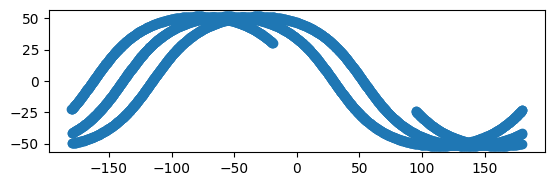

In [146]:
# general trajectories
iss_gdf.plot()

<Axes: >

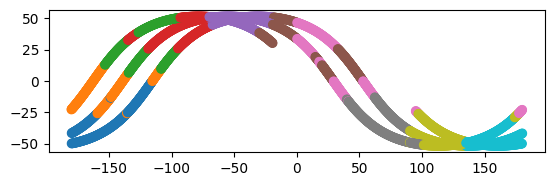

In [147]:
# trajectories color coded by country

# iss_gdf.plot("country")

iss_gdf.plot("geometry")
# you have to make it sort the colors by geometry instead of country or else it will just sort it alphabetically

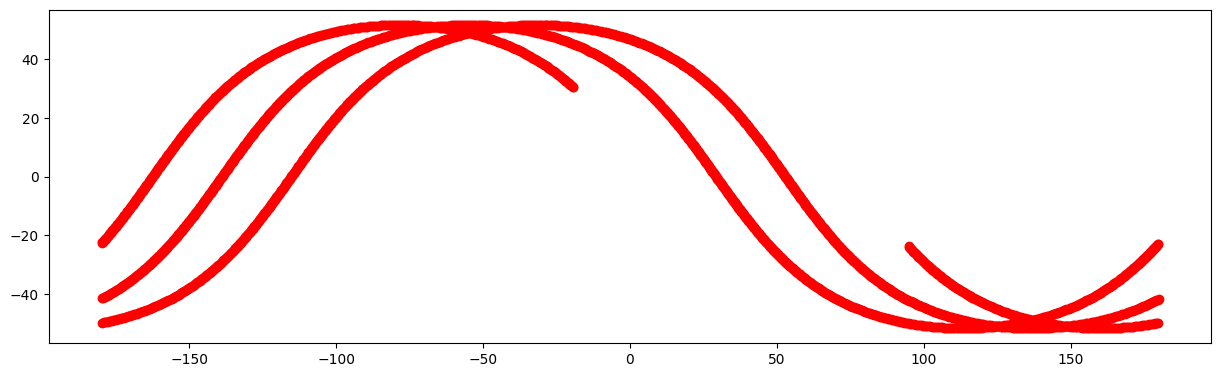

In [148]:
gdf_path = gpd.GeoDataFrame(df, crs={'init': 'epsg:4326'})
gdf_path.plot(figsize=(15,10), color='red');

In [149]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


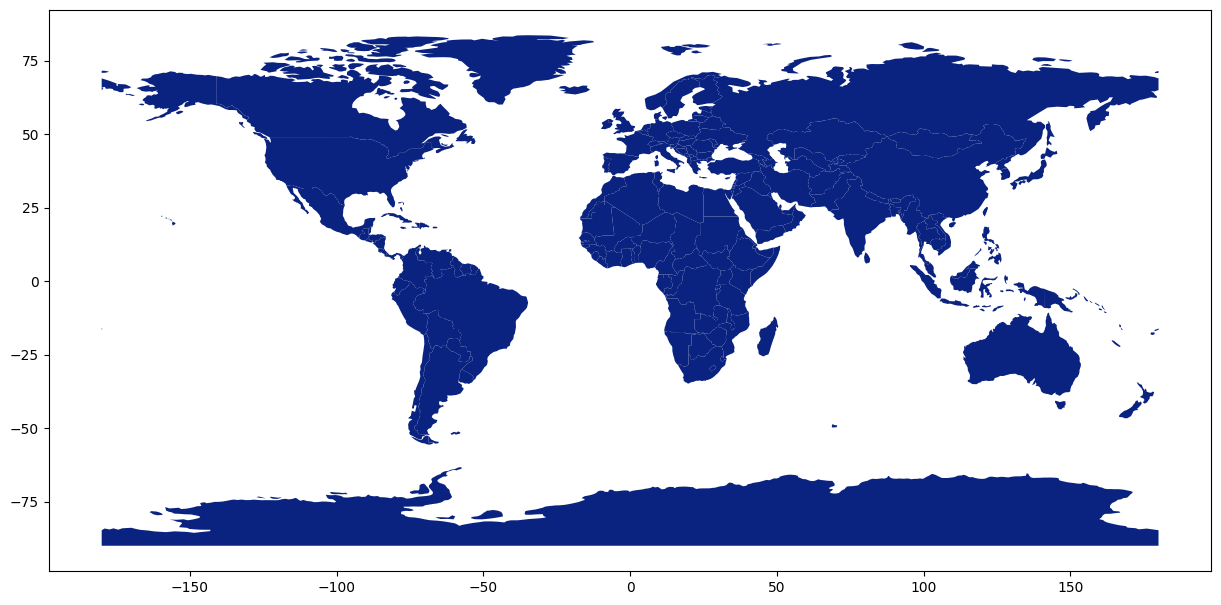

In [150]:
# world map
world.plot(figsize=(15,10),  color='#0B2380');

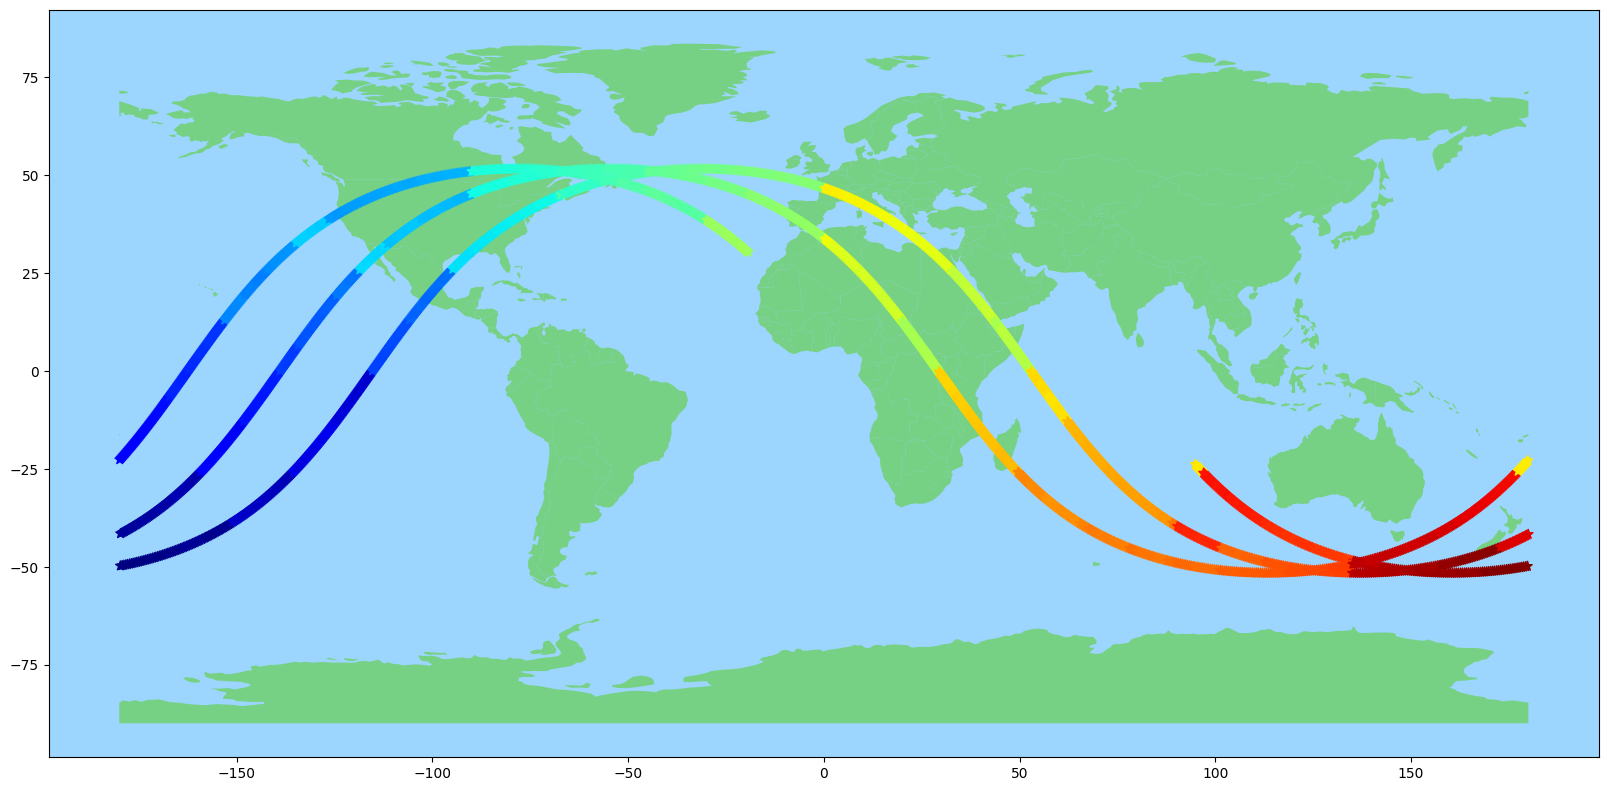

In [151]:
# plotting iss position over earth

# fig, ax = plt.subplots(1, figsize=(15,10))
# base = world.plot(ax=ax, color='#6eff82',)
# base.set_facecolor('#9CD6FF')
# iss_gdf.plot("country", ax=base, marker="*", markersize=30, cmap = 'jet');


fig, ax = plt.subplots(1, figsize=(20,10))
base = world.plot(ax=ax, color='#77d184',)
base.set_facecolor('#9CD6FF')
iss_gdf.plot("geometry", ax=base, marker="*", markersize=50, cmap = 'jet');

# geometry instead of country

<Axes: >

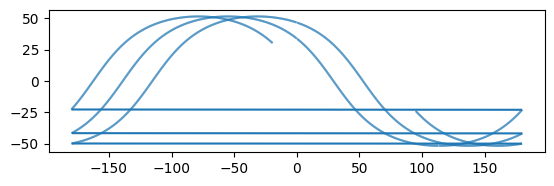

In [152]:
iss_trajc = mpd.TrajectoryCollection(gdf_path,
                                 x = "longitude", y="latitude",
                                 traj_id_col="traj_id", t="t")
iss_trajc.plot()

# **Step 7: Create interactive plots:**
---

<Axes: >

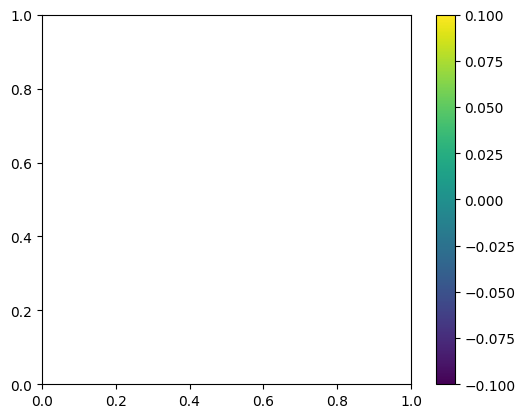

In [157]:
iss_trajc.trajectories[1].plot(legend="true", column="temp")